In [1]:
import os
import pickle
import networkx as nx
import fa2
import numpy as np

from datautils import (
    datautils,
    stats,
)
from graph import graph
from style import style

# from community import community_louvain 
# from collections import (
    # Counter,
    # defaultdict,
# )

# import matplotlib.pyplot as plt
from matplotlib import cm

### Loading the data

In [2]:
# Aleks: Loader jest na tyle szybki, ze nie ma sensu tworzyc pickle z dataframem, ktory sam w sobie zajmuje ~80Mb
# Basia: u mnie na komputerze nie jest to szybkie więc na razie to zostawię, na końcu oczywiscie mozna usunac 

if os.path.exists('data/data_all.pickle'):
    with open('data/data_all.pickle', "rb") as rbfile:
        data = pickle.load(rbfile)
else:
    loader = datautils.Loader()
    loader.load("data/characters/")
    data = loader.to_dataframe()
    loader.drop()
        # with open('data/data_all.pickle', "wb") as wbfile:
        #     pickle.dump(data, wbfile)

### Creating Directed Graph, Directed Largest Connected Components Graph, and Un-directed Largest Connected Components Graph

In [3]:
UNIVERSE_EDGELIST_PATH = "graph/universe.edgelist"

if os.path.exists(UNIVERSE_EDGELIST_PATH):
    Universe = nx.read_edgelist(UNIVERSE_EDGELIST_PATH, create_using=nx.DiGraph)
else:
    Universe = graph.create_directed_graph(data)
    # save graph as an edgelist
    nx.write_edgelist(Universe,UNIVERSE_EDGELIST_PATH)

print("Directed graph:")
print(f"Number of nodes: {len(Universe.nodes)}")
print(f"Number of links: {len(Universe.edges)}")
print("\n")

Universe_CC = graph.connected_components(Universe)
print("Large Connected Components directed graph:")
print(f"Number of nodes: {len(Universe_CC.nodes)}")
print(f"Number of links: {len(Universe_CC.edges)}")

Universe_CC_undirected = Universe_CC.to_undirected()
print("\n")
print("Large Connected Components undirected graph:")
print(f"Number of nodes: {len(Universe_CC_undirected.nodes)}")
print(f"Number of links: {len(Universe_CC_undirected.edges)}")

Directed graph:
Number of nodes: 22967
Number of links: 91910


Large Connected Components directed graph:
Number of nodes: 19078
Number of links: 86559


Large Connected Components undirected graph:
Number of nodes: 19078
Number of links: 62697


### From further analysis only LCC graph will be used



==================== Universe stats ====================

In degree: {'mean': 4.537110808260824, 'median': 2.0, 'mode': 1, 'min': 0, 'max': 915}
Out degree: {'mean': 4.537110808260824, 'median': 3.0, 'mode': 1, 'min': 0, 'max': 390}


Calculating best minimal value for power law fit
In degree slope: 2.55


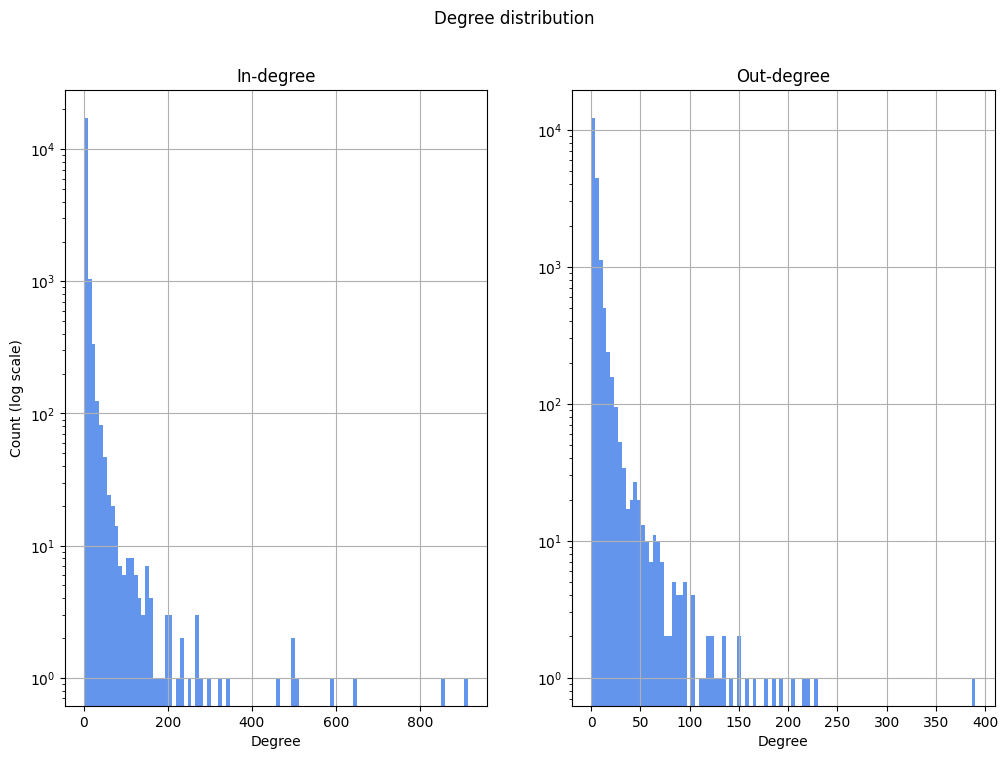

In [4]:
# calculater degree distributions
print("\n")
style.print_header("Universe stats")
in_stats = stats.calc_stats(Universe_CC.in_degree())
out_stats = stats.calc_stats(Universe_CC.out_degree())
print(f"In degree: {in_stats}")
print(f"Out degree: {out_stats}")

print("\n")
print(f"In degree slope: {graph.power_law_fit(Universe_CC):.2f}")    

in_degree, out_degree = graph.plot_degree_distribution(Universe_CC, scale = 'log')

### Visualize Base Graph

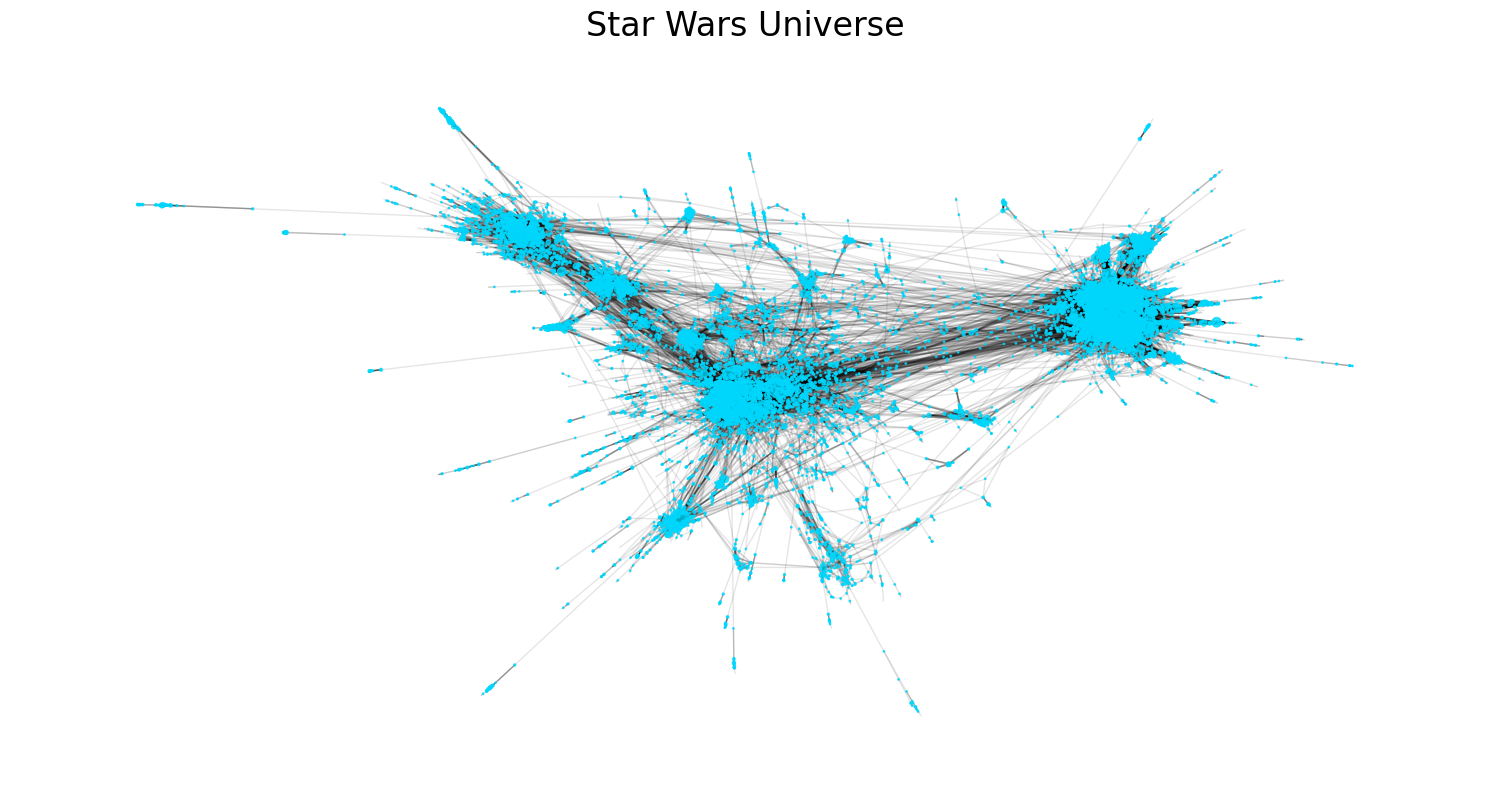

In [5]:
FA_POSITIONS = "data/positions.pickle"

# load pickle with pre-calculated positions if present
if os.path.exists(FA_POSITIONS):
    with open(FA_POSITIONS, "rb") as rbfile:
        positions = pickle.load(rbfile)
else:
    positions = fa2.ForceAtlas2().forceatlas2_networkx_layout(Universe_CC, pos=None, iterations=2000)
    # save to pickle for later use
    with open(FA_POSITIONS, "wb") as wbfile:
        pickle.dump(positions, wbfile)

graph.plot_graph_with_positons(Universe_CC_undirected, positions, "Star Wars Universe")

### Most popular characters

In [6]:
print("Characters with the biggest number of in degree:")
for i in range(10):
    print(f"{i+1}) {list(Universe.nodes())[np.argsort(in_degree)[::-1][i]]}")

print("\n")
print("Characters with the biggest number of out degree:")

for i in range(10):
    print(f"{i+1}) {list(Universe.nodes())[np.argsort(out_degree)[::-1][i]]}")

Characters with the biggest number of in degree:
1) Boba_Fett
2) Drelfin
3) Shoan_Kilian
4) Isolder
5) Coleman_Kcaj
6) Semage
7) Cylo
8) Almec
9) Tenth_Brother
10) Wuher


Characters with the biggest number of out degree:
1) Boba_Fett
2) Semage
3) Cylo
4) Cal_Omas
5) Tenth_Brother
6) Sedriss_QL
7) Gorc
8) Kaat_Thrick-Thrick
9) Coleman_Kcaj
10) Drelfin


In [7]:
# tutaj Leia powtarza się dwa razy, nie wiem czy zostawiamy i piszemy o tym w raporcie czy łączymy to w jedną osobę
data[data.Name.isin(["Leia_Skywalker_Organa_Solo", "Leia_Organa_Solo"])]

,Name,DisplayName,Content,Crosslinks,Species,Gender,Affiliation(s),Homeworld,Died
13413,Leia_Organa_Solo,Leia Organa Solo,"Leia Organa Solo , a Force-sensitive Human fem...","[Star_Wars_Legends, Wookieepedia:Featured_arti...",Human,Female,"[Galactic Empire, House Organa, Alderaanian Re...",Alderaan,"[0 ABY, Bedlam, 2 ABY, Mimban]"
13414,Leia_Skywalker_Organa_Solo,Leia Skywalker Organa Solo,Leia Skywalker Organa Solo was a Force-sensiti...,"[Canon, Leia_Skywalker_Organa_Solo, Leia_Organ...",Human,Female,"[Skywalker family, Elder Houses, House of Orga...",Alderaan,"[35 ABY, Ajan Kloss]"


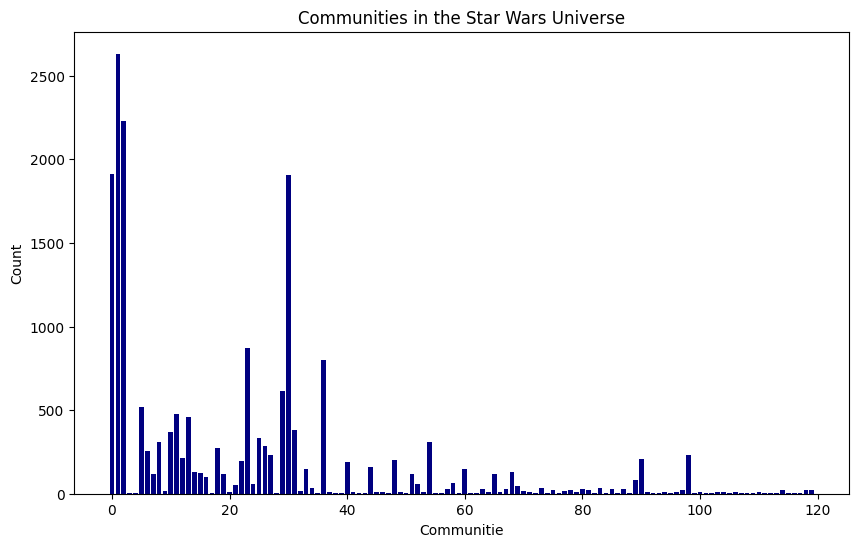

In [8]:
partition, communities = graph.find_communities(Universe_CC_undirected)
graph.plot_communities(communities)

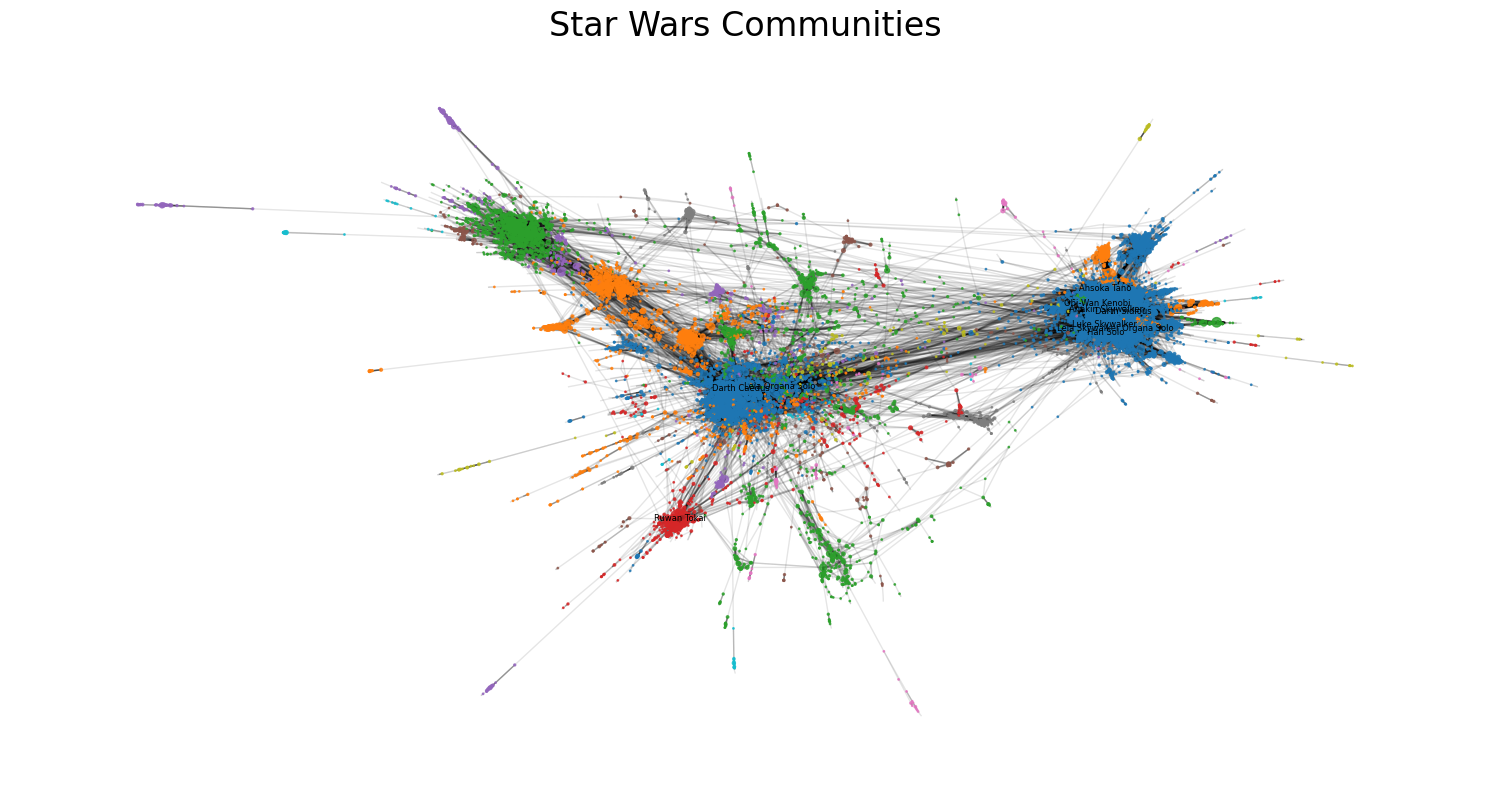

In [9]:
node_degrees = sorted(Universe_CC_undirected.degree, key=lambda x: x[1], reverse=True)
labels = dict([(name[0], data[data.Name == name[0]].DisplayName.values[0]) for name in node_degrees[:10]])

cmap = cm.get_cmap("tab10", max(partition.values()) + 1)

graph.plot_graph_with_positons(
    Universe_CC_undirected,
    positions,
    "Star Wars Communities",
    node_color=list(partition.values()),
    labels = labels,
    cmap = cmap
)